# Simulated Chromosome 
March 19, 2023.  Tutorial written by Ben Ruben (benruben@g.harvard.edu)

In this tutoral, we will demonstrate how to simulate a constant-force and constant-distance pulling of mitotic chromosomes using the openMiChroM library.  These methods were used in the paper "Structural Reogranization and Relaxation Dynamics of Axially Stressed Chromosomes," published in the Biophysical Journal (DOI:https://doi.org/10.1016/j.bpj.2023.03.029).  This tutorial constains two parts:
## Part 1: Constant-Force Pulling
1. Load a polymer from a condensed starting conformation and define the Homopolymer, Ideal Chromosome, and Type-Type potentials
2. Define and add the "Pin" and "Slide" pulling potentials and equilibrate.
3. Define a constant pulling forces which act on the centers of mass of the "pull groups" defined as the first and last 50 beads of the polymer.
4. Apply constant pulling force and measure end-to-end distance under force.  Save pulled structures for following CD simulations
5. Release constnat force and measure extension as the chromosome retracts.

## Part 2: Constant-Distance Pulling
In this section, we deminstrate a constant-distane pulling experiment which measured the force-extension curve of the chromosome.  Frames generated in thne constant-force pulling simulation are used as starting structures for simulations.  After the simulations, we plot a rough force-extension curve.

In [1]:
# from openmichrolib import Akroma as openmichrom
# from openmichrolib import SerraAngel as trainertool
from openmichrom.ChromDynamics import MiChroM

import time
import numpy as np

# from simtk.openmm.app import *
# import simtk.openmm as openmm
# import simtk.unit as units
from sys import stdout, argv
import numpy as np
from six import string_types
import os
import time
import random
import h5py
from scipy.spatial import distance
import scipy as sp
import itertools
import matplotlib.pyplot as plt

plt.rcParams.update({'font.size': 16, 'figure.figsize': [6.0, 5.0]})

Unable to load OpenMM as 'openmm'. Will try the older way 'simtk.openmm'
Unable to load OpenMM as 'openmm'. Will try the older way 'simtk.openmm'


# Part 0: Setting Up Input Files

The folder "input" contains two files: 
-DT40_chr7.eigen contains the A/B type labels of each locus in the chromosome.
-lambdas_ic_15m contains the ideal chromosome interaction parameters learned for the mitotic DT40 chromosome.

We will create two additional input files used to set up the simulations.  The first is a text file which contains the type labels, constructed from the .eigen file:

In [2]:
%%bash
awk '{if ($1 < 0) print "B1"; else print "A1"}' input/DT40_chr7.eigen | cat -n > input/DT40_chr7.txt

#Show the first 10 lines of the text file:
head input/DT40_chr7.txt

     1	A1
     2	A1
     3	A1
     4	A1
     5	A1
     6	A1
     7	A1
     8	A1
     9	A1
    10	A1


Next, we create a text file containing a table of the type-type interaction parameters:

In [3]:
%%bash
echo "A1,B1
-1.644455115938274231e-02, -2.043214285797510181e-03
-2.043214285797510181e-03 ,-1.512813001184262077e-02" > input/lambda_DT40_15m

cat input/lambdas_types_15m

A1,B1
-1.644455115938274231e-02, -2.043214285797510181e-03
-2.043214285797510181e-03 ,-1.512813001184262077e-02


In [4]:
#Auxilary Function Used to Read Coordinates from PDB Files.
def load_Coords_PDB(filename):
        print('Coords Only')
        aFile = open(filename,'r')
        pos = aFile.read().splitlines()
        x = []
        y = []
        z = []

        for t in range(len(pos)):
            pos[t] = pos[t].split()
            if pos[t][0] == 'ATOM':
                x.append(float(pos[t][5]))
                y.append(float(pos[t][6]))
                z.append(float(pos[t][7]))

        return np.vstack([x,y,z]).T

# Part 1: Constant-Force Simulation (Stress-Relaxation Experiment)

## Simulation Parameters:

In [5]:
force = 50

#platform = 'cuda'#Use cuda for nvidia GPUs.  
#Note: GPU must support 64-bit atomic calculations to use CustomCentroidBondForce class in openmm
platform = 'cpu' #use cpu if gpu supporting 64-bit atomic graphics is not available.  

blockSize = 10 #Pull Coordinate is recorded every block, whicih is every 10 steps
bs = blockSize
numBlocks_nat = 2*10**2#2*10**3 #Number of simulation blocks to simulate before applying pulling force
numBlocks_pull = 10**3#10**4 #Number of simulation blocks to run under constant pulling force
numBlocks_release = 2*10**2#2*10**3 #Number of simulation blocks to run after releasing constant force.

blocksPerFrame = 50#500 #Positions of all beads are recorded every frame

CDInits = []#List of filenames to be used later for CD simulations

## Function that retrieves pull coordinate:

In [6]:
#This function retrieves the pull coordinate, defined as the distance between the centers of mass of the pull groups, along the x-axis.
def getPCoord(group1, group2, positions):
    first_centroid = np.mean(positions[group1], axis=0) 
    second_centroid = np.mean(positions[group2], axis=0)

    ## calculate r0 distance between groups

    return np.sqrt( (first_centroid[0] - second_centroid[0])**2 )

## Functions to create pin, slide, and pull forces

We use center of mass pulling actng on the pull groups, defined as the first and last 50 beads in the polymer:

\begin{equation} \label{COMs}
\begin{split}
\mathbf{R}_{left} = &(x_l, y_l, z_l) = \frac{1}{50}\sum_{i=1}^{50} \mathbf{r}_i \\
\mathbf{R}_{right} = &(x_r, y_r, z_r) = \frac{1}{50}\sum_{i=N-49}^{N} \mathbf{r}_i
\end{split}
\end{equation}

We define a pull coordinate $\xi = x_r - x_l$, as the chromosome's end-to-end x-distance.  In chromosome pulling experiments, the ends of the chromosome are held by micropipettes and one is moved along a linear track.  To mimic this process, we introduce orientation constraints:
\begin{equation} \label{PinSlide_Main}
\begin{split}
&\mathbf{U}_{pin} = \frac{1}{2} k_r (x_l^2 + y_l^2 + z_l^2) \\
&\mathbf{U}_{slide} = \frac{1}{2} k_r (y_r^2 + z_r^2)
\end{split}
\end{equation}
$\mathbf{U}_{pin}$ restrains the center of mass of the left pull group to the origin.  $\mathbf{U}_{slide}$ restrains the right pull group to the x-axis, but allows it to slide along the x-axis.  A large value $k_r = 10^5 \epsilon/\sigma^2$ is used so that $\mathbf{R}_{left} \approx 0$ and $y_r, z_r \approx 0$.  We use two methods to subject the simulated chromosomes to axial strain.  In constant-force (CF) pulling, a linear potential is used to apply a constant elongating force to the pull coordinate $\xi$.  In constant-distance (CD) pulling, a harmonic potential with a very strong spring constant is used to constrain $\xi$ to a very small window around a chosen reference distance $\xi_0$.
\begin{equation} \label{CFCDPotentials}
\begin{split}
&\mathbf{U}_{CF} = - F \xi\\
&\mathbf{U}_{CD} = \frac{1}{2} k_p (\xi -\xi_0)^2
\end{split}
\end{equation}
A large value of $k_p = 10^5 \epsilon/\sigma^2$ is chosen so that $\xi \approx \xi_0$ during CD sampling.

These potentials are implemented in the functions in the cell below:

In [7]:
#This function is used in Constant-Distance pulling experiments.  It defines a harmonic restraining potential on the pull coordinate.
def harmonic_pull_force(group1, group2, r0, kp):
    import simtk.openmm as openmm
    
    #r0 = r0 * units.meter * 1e-9
    pullequation = "0.5 * kpull * ((x2-x1)- rp)^2" #Enforces x2>x1

    pullforce = openmm.CustomCentroidBondForce(2, pullequation)

    pullforce.addGlobalParameter('kpull', kp)
    pullforce.addGlobalParameter('rp', r0)
    pullforce.addGroup(group1)
    pullforce.addGroup(group2)
    pullforce.addBond([0,1])
    #pullforce.setForceGroup(8)
    return(pullforce)

#This function is used in Constant-Force pulling.  It applies a constant force between the centers of mass of the pull groups.  Written as a potential energy, this is a linear function of the pull coordinate.
def constant_pull_force(group1, group2, f):
    import simtk.openmm as openmm
    
    #Pulls x2 to the right and x1 to the left
    pullequation = "-1*f*(x2-x1)"

    pullforce = openmm.CustomCentroidBondForce(2, pullequation)

    pullforce.addGlobalParameter('f', f)
    pullforce.addGroup(group1)
    pullforce.addGroup(group2)
    pullforce.addBond([0,1])
    return(pullforce)

#This potential energy keeps the left pull group near the origin of the coordinate system.
def pin_force(group1, kpin=100):
    import simtk.openmm as openmm
    
    #r0 = r0 * units.meter * 1e-9
    pullequation = "0.5 * kpin * (x1^2+y1^2+z1^2)"

    pullforce = openmm.CustomCentroidBondForce(1, pullequation)

    print(str(kpin))
    pullforce.addGlobalParameter('kpin', kpin)
    pullforce.addGroup(group1)
    pullforce.addBond([0])
    return(pullforce)

#This potential energy keeps the right pull group near the positive x-axis.
def slide_force(group1, x_min=0, kslide = 100):
    import simtk.openmm as openmm
    
    pullequation = "0.5 * kslide * ((step(x_min-x1)*((x_min-x1)^2))+y1^2+z1^2)"

    pullforce = openmm.CustomCentroidBondForce(1, pullequation)

    pullforce.addGlobalParameter('kslide', kslide)
    pullforce.addGlobalParameter('x_min', x_min)
    pullforce.addGroup(group1)
    pullforce.addBond([0])
    return(pullforce)

## Sets up simulation and loads initial structure

In [8]:
##Start openMiChroM library
sim = MiChroM(name='sim', temperature=120)
sim.setup(platform=platform, integrator="Langevin")

    ***************************************************************************************     
     **** **** *** *** *** *** *** *** OpenMiChroM-1.0.5 *** *** *** *** *** *** **** ****      

         OpenMiChroM is a Python library for performing chromatin dynamics simulations.         
                            OpenMiChroM uses the OpenMM Python API,                             
                employing the MiChroM (Minimal Chromatin Model) energy function.                
      The chromatin dynamics simulations generate an ensemble of 3D chromosomal structures      
      that are consistent with experimental Hi-C maps, also allows simulations of a single      
                 or multiple chromosome chain using High-Performance Computing                  
                            in different platforms (GPUs and CPUs).                             
         OpenMiChroM documentation is available at https://open-michrom.readthedocs.io          

         OpenMiChroM is desc

In [9]:
#Folder to save outputs
sim.saveFolder('output_files')

In [10]:
#Creates an initial state
mypol = sim.createSpringSpiral(ChromSeq='input/DT40_chr7.txt')

In [11]:
#Load initial conformation into the system.  Uses pre-oriented and equilibrated input structure
sim.loadStructure(mypol, center=False)
dataToLoad = load_Coords_PDB('condensed.pdb')
sim.loadStructure(dataToLoad, center=False)

Coords Only


In [12]:
#Adds Homopolymer forces
sim.addFENEBonds(kfb=30.0)
sim.addAngles(ka=1.0)
sim.addRepulsiveSoftCore(Ecut=4.0)

In [13]:
#Adds type-type potential for mitotic chromosome
#type_lambs = sim_aux.getlambfromfile('input/types-DT40-15m')
sim.addCustomTypes(mu=1.51, rc = 2.12, TypesTable='input/lambdas_types_15m')

In [14]:
#Adds Ideal Chromosome potential for mitotic chromosome
sim.addCustomIC(mu=1.51, rc = 2.12, dinit=3, dend=735, IClist = 'input/lambdas_ic_15m')

### Define pull groups.

In [15]:
index = [ index for index in range(len(sim.getPositions())) ]
g1 = index[:50] #Left pull group is the first 50 beads
g2 = index[-50:] #Right pull group is the last 50 beads

positions = sim.getPositions() #get the position of each bead

first_centroid = np.mean(positions[g1], axis=0) 
print("Location of the left pull group:")
print(first_centroid)

second_centroid = np.mean(positions[g2], axis=0)
print("\nLocation of the right pull group:")
print(second_centroid)

## calculate r0 distance between groups

r0 = np.sqrt( (first_centroid[0] - second_centroid[0])**2)

print("\nInitial distance between groups is r = {}".format(r0))

Location of the left pull group:
[-6.873404   -0.9451998  -0.65241516]

Location of the right pull group:
[ 7.4524355 -1.0049996 -0.6166145]

Initial distance between groups is r = 14.32583999633789


## WARNING! -- Orient Initial Structures
The initial structure used here has been pre-oriented so that the left pull group is very near to the origin and the right pull group is very near to the positive x-axis.  This is so that the pin and slide potentials do not generate very large forces on the initial structure.  When performing simulations with an arbitrary starting structure, make sure to rotate the coordinates so that it aligns with the restraining potentials.

In [16]:
pforce_sim = constant_pull_force(g1,g2, 0)#We first set the pull force to 0
sim.forceDict["pulling"] =  pforce_sim

pin_force_sim = pin_force(g1, kpin=100) #here we using x_pos = 0 and kp = 100
sim.forceDict["pin"] = pin_force_sim

# Pin right end to positive x-axis
slide_force_sim = slide_force(g2, kslide=100) #here we using x_pos = 0 and kp = 100
sim.forceDict["slide"] = slide_force_sim

100


In [17]:
#define name to save .cndb
sim.initStorage('CF_traj', mode='w')

In [18]:
#Matrix to save time
time_record = []

#Matrix to save pull coordinate
pcoord = []

#Matrix to save frame labels
flabels = []

#Append Initial pcoord and time:
time_record.append(0)
pcoord.append(getPCoord(g1, g2, sim.getPositions()))

## Native Simulation
We first simulate without adding a pulling force.

In [19]:
#run simulation
time1 = time.time()

#Save Initial Configuration
#sim.save()
flabels.append(sim.step)

nb = numBlocks_nat

#Start Simulation
for t in range(1, nb+1):
    
    sim.runSimBlock(bs, increment=True) #relaxamento
    
    #Recurd Pulling Data Every Block!
    time_record.append(sim.timestep*t*bs)
    pcoord.append(getPCoord(g1, g2, sim.getPositions()))
    
    if t% blocksPerFrame == 0:
        ##save trajectory
        sim.saveStructure()
        flabels.append(sim.step)
time2 = time.time()
print('This run took {:.2f} seconds'.format(time2-time1))

Number of exceptions: 738
adding force  FENEBond 0
adding force  AngleForce 1
Add exclusions for RepulsiveSoftCore force
adding force  RepulsiveSoftCore 2
Add exclusions for CustomTypes force
adding force  CustomTypes 3
Add exclusions for CustomIC force
adding force  CustomIC 4
adding force  pulling 5
adding force  pin 6
adding force  slide 7
Positions... 
 loaded!
potential energy is 21.005716
bl=1 pos[1]=[-6.0 -3.0 1.5] dr=0.07 t=0.1ps kin=4.39 pot=21.66 Rg=5.370 SPS=173 
bl=2 (i) pos[1]=[-6.0 -3.0 1.4] dr=0.10 t=0.2ps kin=6.71 pot=22.64 Rg=5.369 SPS=126 
bl=3 (i) pos[1]=[-6.0 -3.0 1.5] dr=0.08 t=0.3ps kin=5.51 pot=22.28 Rg=5.367 SPS=180 
bl=4 (i) pos[1]=[-6.0 -3.0 1.5] dr=0.08 t=0.4ps kin=5.13 pot=22.13 Rg=5.366 SPS=155 
bl=5 pos[1]=[-6.0 -3.0 1.6] dr=0.07 t=0.5ps kin=4.89 pot=22.06 Rg=5.365 SPS=78 
bl=6 (i) pos[1]=[-5.9 -3.0 1.6] dr=0.11 t=0.6ps kin=7.56 pot=23.16 Rg=5.364 SPS=130 
bl=7 (i) pos[1]=[-5.8 -3.0 1.6] dr=0.08 t=0.7ps kin=5.85 pot=22.33 Rg=5.364 SPS=149 
bl=8 (i) pos[1]=

In [20]:
#Save zero force structure to ndb file
sim.saveStructure(mode = 'pdb')
CDInits.append('output_files/'+sim.name +"_0_block%d." % sim.step + 'pdb')

## Constant Force

In [21]:
#Update the force parameter to the specified pulling force.
sim.context.setParameter('f', force)

In [22]:
#run simulation
time1 = time.time()

nb = numBlocks_pull

In [23]:
#Start Simulation
for t in range(1, nb+1):
    
    sim.runSimBlock(bs, increment=True) #relaxamento
    
    #Recurd Pulling Data Every Block!
    time_record.append(sim.timestep*t*bs)
    pcoord.append(getPCoord(g1, g2, sim.getPositions()))
    
    if t% blocksPerFrame == 0:
        ##save trajectory
        sim.saveStructure()
        #Save pdb structures throughout pulling 
        sim.saveStructure(mode = 'pdb')
        CDInits.append('output_files/'+sim.name +"_0_block%d." % sim.step + 'pdb')
        flabels.append(sim.step)
time2 = time.time()
print('This run took {:.2f} seconds'.format(time2-time1))

bl=201 (i) pos[1]=[-5.0 -1.6 1.7] dr=0.08 t=20.1ps kin=5.07 pot=20.62 Rg=5.240 SPS=146 
bl=202 pos[1]=[-5.0 -1.6 1.7] dr=0.07 t=20.2ps kin=4.99 pot=20.53 Rg=5.240 SPS=146 
bl=203 (i) pos[1]=[-4.9 -1.6 1.7] dr=0.10 t=20.3ps kin=7.51 pot=21.71 Rg=5.239 SPS=123 
bl=204 (i) pos[1]=[-5.0 -1.5 1.7] dr=0.08 t=20.4ps kin=5.62 pot=21.00 Rg=5.239 SPS=121 
bl=205 (i) pos[1]=[-5.0 -1.5 1.6] dr=0.08 t=20.5ps kin=5.04 pot=20.72 Rg=5.239 SPS=140 
bl=206 (i) pos[1]=[-4.9 -1.5 1.7] dr=0.08 t=20.6ps kin=5.08 pot=20.52 Rg=5.237 SPS=147 
bl=207 pos[1]=[-4.9 -1.5 1.7] dr=0.08 t=20.7ps kin=4.82 pot=20.64 Rg=5.238 SPS=114 
bl=208 (i) pos[1]=[-4.9 -1.5 1.6] dr=0.10 t=20.8ps kin=7.30 pot=21.64 Rg=5.240 SPS=132 
bl=209 (i) pos[1]=[-4.9 -1.5 1.6] dr=0.08 t=20.9ps kin=5.87 pot=20.97 Rg=5.242 SPS=156 
bl=210 (i) pos[1]=[-4.9 -1.5 1.7] dr=0.08 t=21.0ps kin=5.05 pot=20.72 Rg=5.241 SPS=125 
bl=211 (i) pos[1]=[-4.9 -1.5 1.7] dr=0.08 t=21.1ps kin=5.08 pot=20.53 Rg=5.241 SPS=154 
bl=212 pos[1]=[-4.9 -1.6 1.7] dr=0.07 t=

## Release Simulation

In [24]:
#Update the force parameter to the specified pulling force.
sim.context.setParameter('f', 0)

In [25]:
#run simulation
time1 = time.time()

nb = numBlocks_release

#Start Simulation
for t in range(1, nb+1):
    
    sim.runSimBlock(bs, increment=True) #relaxamento
    
    #Recurd Pulling Data Every Block!
    time_record.append(sim.timestep*t*bs)
    pcoord.append(getPCoord(g1, g2, sim.getPositions()))
    
    if t% blocksPerFrame == 0:
        sim.saveStructure()
        flabels.append(sim.step)
time2 = time.time()
print('This run took {:.2f} seconds'.format(time2-time1))

bl=1201 (i) pos[1]=[-2.9 -1.5 4.3] dr=0.08 t=120.1ps kin=5.40 pot=20.48 Rg=5.242 SPS=143 
bl=1202 (i) pos[1]=[-2.9 -1.5 4.3] dr=0.08 t=120.2ps kin=5.05 pot=20.42 Rg=5.240 SPS=131 
bl=1203 (i) pos[1]=[-2.9 -1.5 4.3] dr=0.08 t=120.3ps kin=5.04 pot=20.37 Rg=5.241 SPS=120 
bl=1204 (i) pos[1]=[-2.9 -1.6 4.3] dr=0.08 t=120.4ps kin=5.20 pot=20.32 Rg=5.242 SPS=179 
bl=1205 pos[1]=[-2.9 -1.6 4.2] dr=0.08 t=120.5ps kin=4.77 pot=20.31 Rg=5.240 SPS=207 
bl=1206 (i) pos[1]=[-2.8 -1.5 4.2] dr=0.10 t=120.6ps kin=7.04 pot=21.44 Rg=5.239 SPS=192 
bl=1207 (i) pos[1]=[-2.8 -1.6 4.2] dr=0.08 t=120.7ps kin=5.54 pot=20.71 Rg=5.238 SPS=149 
bl=1208 (i) pos[1]=[-2.7 -1.5 4.2] dr=0.08 t=120.8ps kin=5.43 pot=20.30 Rg=5.237 SPS=162 
bl=1209 pos[1]=[-2.7 -1.6 4.3] dr=0.08 t=120.9ps kin=4.81 pot=20.35 Rg=5.237 SPS=163 
bl=1210 (i) pos[1]=[-2.7 -1.6 4.3] dr=0.10 t=121.0ps kin=7.47 pot=21.40 Rg=5.239 SPS=169 
bl=1211 (i) pos[1]=[-2.7 -1.6 4.2] dr=0.08 t=121.1ps kin=5.82 pot=20.70 Rg=5.240 SPS=210 
bl=1212 (i) pos[1]

In [26]:
#close storage file
sim.storage[0].close()

#save last conformation in pdb
sim.saveStructure(mode = 'pdb')

In [27]:
#Save Time and Pull Coordinate to output file.
coordinfo = np.vstack([time_record, pcoord]).T
np.savetxt('output_files/CF_Pull_Coord.txt', coordinfo)

# Plot Pull Coordinate
We may now plot the end-to-end distance as a function of time during the constant-force experiment.  The vertical lines indicate when force is applied and released.

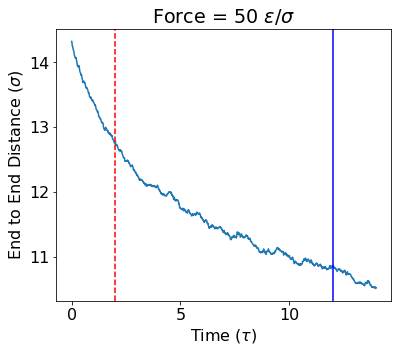

In [28]:
all_times = sim.timestep*np.array(range(len(pcoord)))
all_pcoord = pcoord

fig, ax = plt.subplots()
ax.plot(all_times, all_pcoord)
ax.set_xlabel(r"Time ($\tau$)")
ax.set_ylabel(r"End to End Distance ($\sigma$)")
ax.set_title('Force = '+ str(force) + r" $\epsilon/\sigma$")
ax.axvline(x=all_times[numBlocks_nat], ls='--', color = 'r')
ax.axvline(x = all_times[numBlocks_nat+numBlocks_pull], color = 'b')

# Part 2: Constant-Distance Pulling

In [ ]:
numDists = 5
kpull = 10**5 #A very strong spring constant is used to restrain the end-to-end distance to a small window.
numBlocks_CD = 10000 #number of blocks to run each CD simulation

xiVals = [] #Array to store pull coordinates used for pulling
forceVals = []#Array to store measured forces

Each iteration of the below loop runs a constant-distance pulling simulation at the distances corresponding to the starting structures saved from the stress relaxation simulation.

In [ ]:
CDInits

In [ ]:
for distNum in range(0, numDists+1):
    
    print('Starting Simulation ' + str(distNum))
    #Sets up a new simulation
    sim = MiChroM(name='sim', temperature=120)
    sim.setup(platform=platform, integrator="Langevin")
    
    #Folder to save outputs
    sim.saveFolder('output_files_CD_'+str(distNum))
    
    #Creates an initial state
    mypol = sim.createSpringSpiral(ChromSeq='input/DT40_chr7.txt')
    
    
    #Load initial conformation into the system.  Uses outputs of CF Simulation as starting points.
    sim.loadStructure(mypol, center=False)
    coords = load_Coords_PDB(CDInits[distNum])
    sim.loadStructure(coords, center = False)#Sets coordinates to initial structure.

    #Adds Homopolymer forces
    sim.addFENEBonds(kfb=30.0)
    sim.addAngles(ka=1.0)
    sim.addRepulsiveSoftCore(Ecut=4.0)

    #Adds type-type potential for mitotic chromosome
    sim.addCustomTypes(mu=1.51, rc = 2.12, TypesTable='input/lambdas_types_15m')

    #Adds Ideal Chromosome potential for mitotic chromosome
    sim.addCustomIC(mu=1.51, rc = 2.12, dinit=3, dend=735, IClist = 'input/lambdas_ic_15m')
    
    #calculate the initial pull coordinate:
    positions = sim.getPositions()
    
    first_centroid = np.mean(positions[g1], axis=0) 
    print("Location of the left pull group:")
    print(first_centroid)

    second_centroid = np.mean(positions[g2], axis=0)
    print("\nLocation of the right pull group:")
    print(second_centroid)

    ## calculate r0 distance between groups
    r0 = np.sqrt( (first_centroid[0] - second_centroid[0])**2)  
    print('Initial Distance Is: ' + str(r0))
    
    #Add pulling forcers
    pforce_sim = harmonic_pull_force(g1,g2, r0, kpull)
    sim.forceDict["pulling"] = pforce_sim
    
    pin_force_sim = pin_force(g1, kpin=100) #here we using x_pos = 0 and kp = 100
    sim.forceDict["pin"] = pin_force_sim

    # Pin right end to positive x-axis
    slide_force_sim = slide_force(g2, kslide=100) #here we using x_pos = 0 and kp = 100
    sim.forceDict["slide"] = slide_force_sim
    
    pcoord = []
    
    #run simulation
    time1 = time.time()

    #Save Initial Configuration
    #sim.save()
    flabels.append(sim.step)

    nb = numBlocks_CD

    #Start Simulation
    for t in range(1, nb+1):

        sim.runSimBlock(bs, increment=True) #relaxamento

        #Recurd Pulling Data Every Block!
        pcoord.append(getPCoord(g1, g2, sim.getPositions()))

        #if want print forces
        if t % 1000 == 0:
            sim.printForces()
            print("Radius of Gyration: {:.2f}\tBlock: {}/{}".format(sim.RG(), t,nb))
    time2 = time.time()
    print('This run took {:.2f} seconds'.format(time2-time1))
    
    meanDist = np.mean(pcoord)
    meanForce = kpull*(r0-meanDist)
    
    #Add to forces
    forceVals.append(meanForce)
    
    #Add to XiVals:
    xiVals.append(meanDist)

We can now plot a force-extension curve

In [ ]:
fig, ax = plt.subplots()

ax.scatter(xiVals, forceVals)
ax.set_xlabel(r'Extension $(\sigma)$')
ax.set_ylabel(r'Force $(\epsilon/\sigma)$')